In [82]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import re
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
import pickle
import tweepy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from scipy.interpolate import spline

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

## RF

In [83]:
rf_df = pd.read_csv('data/full/1000_new_train.csv')

In [84]:
X_train, X_val, y_train, y_val = train_test_split(rf_df.drop(columns=['target']), rf_df['target'], test_size=0.3)

In [85]:
rf = RandomForestClassifier(n_estimators = 400, max_depth = 28, criterion = 'entropy')

In [86]:
cv = cross_validate(rf, X_train.drop(columns=['user_id']), y_train, cv=10, scoring='f1_macro')

In [87]:
cv['test_score'].mean()

0.9819461304654764

In [88]:
len(X_train.drop(columns=['user_id']).columns)

37

In [89]:
rf.fit(X_train.drop(columns=['user_id']), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
rf_pred = rf.predict_proba(X_val.drop(columns=['user_id']))

In [91]:
rf.predict_proba(X_val.drop(columns=['user_id']).iloc[0:10])

array([[0.02  , 0.09  , 0.885 , 0.005 ],
       [0.9825, 0.    , 0.    , 0.0175],
       [0.9925, 0.0075, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    ],
       [0.985 , 0.    , 0.0075, 0.0075],
       [0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    ],
       [0.4225, 0.    , 0.14  , 0.4375],
       [0.    , 0.    , 0.    , 1.    ]])

In [92]:
rf_prob = pd.DataFrame(rf_pred, columns=['rf_0', 'rf_1', 'rf_2', 'rf_3'])

In [93]:
X_val.reset_index(inplace=True, drop=True)

In [94]:
rf_prob.reset_index(inplace=True, drop=True)

In [95]:
y_val.reset_index(inplace=True, drop=True)

In [96]:
rf_prob['user_id'] = X_val['user_id']

In [97]:
rf_prob['target'] = y_val

In [98]:
rf_prob.head()

,rf_0,rf_1,rf_2,rf_3,user_id,target
0,0.0200,0.0900,0.8850,0.0050,3015205673,1
1,0.9825,0.0000,0.0000,0.0175,30089709,0
2,0.9925,0.0075,0.0000,0.0000,1353858199,0
3,0.0000,0.0000,0.0000,1.0000,1004419494608015360,3
4,0.9850,0.0000,0.0075,0.0075,151240882,0


## NB

In [99]:
users = rf_df[['user_id','target']]

In [100]:
tweets = pd.concat([pd.read_csv('data/propaganda/tweets.csv', sep='\t')[['user_id','full_text']], \
          pd.read_csv('data/porn/tweets.csv', sep='\t')[['user_id','full_text']], \
          pd.read_csv('data/spam/tweets.csv', sep='\t')[['user_id','full_text']], \
          pd.read_csv('data/fake_followers/tweets.csv', sep='\t')[['user_id','full_text']]])

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,4,8,11,18,19,20,23,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
tweets = tweets.drop_duplicates()

In [102]:
tweets = pd.merge(tweets, users, on='user_id')

In [103]:
tweets.target.value_counts()

2    453719
1    280300
0    196712
3     41316
Name: target, dtype: int64

In [104]:
mask = np.in1d(tweets.user_id, X_train.user_id)

In [105]:
val_mask = np.in1d(tweets.user_id, X_val.user_id)

In [106]:
nb_train = tweets[mask]

In [107]:
nb_val = tweets[val_mask]

In [108]:
def remove_rt(x):
    if 'RT @' in x:
        try:
            return x[x.find(':')+2:]
        except:
            return x
    else:
        return x

In [109]:
stop_words = stopwords.words('english')

def remove_stop(x):
    return [word for word in x.split() if word not in stop_words]

In [110]:
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: remove_rt(x))
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: x.lower())
nb_train['full_text'] = nb_train['full_text'].apply(lambda x: remove_stop(x))
nb_train['full_text'] = nb_train['full_text'].astype(str)
nb_train = nb_train[nb_train['full_text']!='[]']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [111]:
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: remove_rt(x))
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', x))
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: re.sub(r'[^\w\s]','',x))
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: x.lower())
nb_val['full_text'] = nb_val['full_text'].apply(lambda x: remove_stop(x))
nb_val['full_text'] = nb_val['full_text'].astype(str)
nb_val = nb_val[nb_val['full_text']!='[]']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [112]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(CountVectorizer, self).build_analyzer()
        return lambda doc:(stemmer.stem(w) for w in analyzer(doc))


stem_vectorizer = StemmedCountVectorizer(stemmer)

pipeline = Pipeline([('vect', stem_vectorizer), 
                     ('tfidf', TfidfTransformer()), 
                     ('mnb', MultinomialNB(fit_prior=False))])

clf = pipeline.fit(nb_train['full_text'], nb_train['target'])

In [113]:
predictions = []
i = 0

for usr in X_val['user_id']:
    
    i+=1
    clear_output()
    print(i)
    tweets_list = nb_val[nb_val.user_id == usr]['full_text']
    tweets_list = tweets_list[tweets_list.notnull()]
    if len(tweets_list[tweets_list.notnull()]) != 0:
        pred = clf.predict_proba(tweets_list)
        predictions.append(np.mean(pred, axis=0))
    else:
        predictions.append(np.array([0.2,0.2,0.2,0.2]))

6434


In [114]:
prob = pd.DataFrame(predictions, columns=['nb_0', 'nb_1', 'nb_2', 'nb_3'])

In [115]:
prob['target'] = rf_prob['target']

In [116]:
prob['user_id'] = X_val['user_id']

## KNN

In [117]:
X_train = X_train[['default_profile', 'favourites_count', 'followers_count', 'friends_count', 'listed_count','profile_use_background_image',
       'statuses_count', 'url', 'description_len', 'name_len', 'screen_name_len', 'age', 'user_id']]

In [118]:
X_val = X_val[['default_profile', 'favourites_count', 'followers_count', 'friends_count', 'listed_count','profile_use_background_image',
       'statuses_count', 'url', 'description_len', 'name_len', 'screen_name_len', 'age', 'user_id']]

In [119]:
weights = pickle.load(open('../scripts/knn.weights', 'rb'))

In [120]:
train = X_train.drop(columns=['user_id']) * weights

In [121]:
val = X_val.drop(columns=['user_id']) * weights

In [122]:
knn = KNeighborsClassifier(p=1, n_neighbors=5)

In [123]:
knn.fit(train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=1,
           weights='uniform')

In [124]:
cv = cross_validate(knn, val, y_val, cv=10, scoring='f1_macro')

In [125]:
cv['test_score'].mean()

0.927797325673569

In [126]:
knn_pred = knn.predict_proba(val)

In [127]:
knn_prob = pd.DataFrame(knn_pred, columns=['knn_0', 'knn_1', 'knn_2', 'knn_3'])

In [128]:
X_val.reset_index(inplace=True, drop=True)

In [129]:
knn_prob.reset_index(inplace=True, drop=True)

In [130]:
y_val.reset_index(inplace=True, drop=True)

In [131]:
knn_prob['user_id'] = X_val['user_id']

In [132]:
knn_prob['target'] = y_val

In [133]:
knn_prob.head()

,knn_0,knn_1,knn_2,knn_3,user_id,target
0,0.0,0.2,0.8,0.0,3015205673,1
1,1.0,0.0,0.0,0.0,30089709,0
2,1.0,0.0,0.0,0.0,1353858199,0
3,0.0,0.0,0.0,1.0,1004419494608015360,3
4,1.0,0.0,0.0,0.0,151240882,0


## Stacking

In [134]:
stack_df = rf_prob.merge(prob, on=['user_id' , 'target'])

In [135]:
stack_df = stack_df.merge(knn_prob, on=['user_id' , 'target'])

In [136]:
stack_df = stack_df.reindex_axis(sorted(stack_df.columns), axis=1)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


In [137]:
stack_df.head()

,knn_0,knn_1,knn_2,knn_3,nb_0,nb_1,nb_2,nb_3,rf_0,rf_1,rf_2,rf_3,target,user_id
0,0.0,0.2,0.8,0.0,0.114627,0.469788,0.385831,0.029754,0.0200,0.0900,0.8850,0.0050,1,3015205673
1,1.0,0.0,0.0,0.0,0.200000,0.200000,0.200000,0.200000,0.9825,0.0000,0.0000,0.0175,0,30089709
2,1.0,0.0,0.0,0.0,0.455257,0.161891,0.294204,0.088648,0.9925,0.0075,0.0000,0.0000,0,1353858199
3,0.0,0.0,0.0,1.0,0.200000,0.200000,0.200000,0.200000,0.0000,0.0000,0.0000,1.0000,3,1004419494608015360
4,1.0,0.0,0.0,0.0,0.200000,0.200000,0.200000,0.200000,0.9850,0.0000,0.0075,0.0075,0,151240882


In [138]:
stack_df.to_csv('data/full/logreg_train.csv', index=False)

In [139]:
stack_df = pd.read_csv('data/full/logreg_train.csv')

In [140]:
stack_df.head()

,knn_0,knn_1,knn_2,knn_3,nb_0,nb_1,nb_2,nb_3,rf_0,rf_1,rf_2,rf_3,target,user_id
0,0.0,0.2,0.8,0.0,0.114627,0.469788,0.385831,0.029754,0.0200,0.0900,0.8850,0.0050,1,3015205673
1,1.0,0.0,0.0,0.0,0.200000,0.200000,0.200000,0.200000,0.9825,0.0000,0.0000,0.0175,0,30089709
2,1.0,0.0,0.0,0.0,0.455257,0.161891,0.294204,0.088648,0.9925,0.0075,0.0000,0.0000,0,1353858199
3,0.0,0.0,0.0,1.0,0.200000,0.200000,0.200000,0.200000,0.0000,0.0000,0.0000,1.0000,3,1004419494608015360
4,1.0,0.0,0.0,0.0,0.200000,0.200000,0.200000,0.200000,0.9850,0.0000,0.0075,0.0075,0,151240882


## Metamodel LogReg training

In [141]:
X = stack_df.drop(columns=['user_id', 'target'])
y = stack_df['target']

In [142]:
def grid_eval(model, X, y, params):
    
    grid = GridSearchCV(model, params, cv=10, scoring='f1_macro')
    grid.fit(X, y)
    
    return pd.DataFrame(grid.cv_results_)

In [339]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, title, filename):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    xnew = np.linspace(grid_param_1[0], grid_param_1[-1], 50)
    
    # Plot Grid search scores
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        score_smooth = spline(grid_param_1, scores_mean[idx,:], xnew)
        ax.plot(grid_param_1, scores_mean[idx,:], '-', label= name_param_2 + ': ' + str(val), linewidth=3)
    
    
    best_index = cv_results['mean_test_score'].values.argmax()
    best_param = cv_results.loc[best_index]['param_max_iter']
    best_param_2 = cv_results.loc[best_index]['param_solver']
    best_score = cv_results['mean_test_score'].max()
    min_score = cv_results['mean_test_score'].min()
    plt.axvline(x=best_param, linestyle=':', color='grey', linewidth=2)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.plot([best_param,], [best_score],
           linestyle=':', color='black', markeredgewidth=3,markersize=26, ms=8)
    
    plt.annotate("%0.4f (max_iter = %d, solver = %s)" % (best_score, best_param, best_param_2),
                    (best_param+1, best_score-0.00001), fontsize=24)

    ax.tick_params(labelsize=20)
    ax.set_title(title, fontsize=30)
    ax.set_xlabel(name_param_1, fontsize=28)
    ax.set_ylabel('F1 Macro Score', fontsize=28)
    ax.legend(loc="best", fontsize=22)
    ax.grid('on')
    
    fig.savefig('data/full/'+ filename +'.png')

## Default LR

In [165]:
params = {'multi_class': ['auto'], 'max_iter': [1,5,10,100,1000], 'penalty': ['l1'], 'solver':['liblinear','saga']}

In [166]:
max_iter = [1,5,10,100,1000]
solver = ['liblinear', 'saga']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


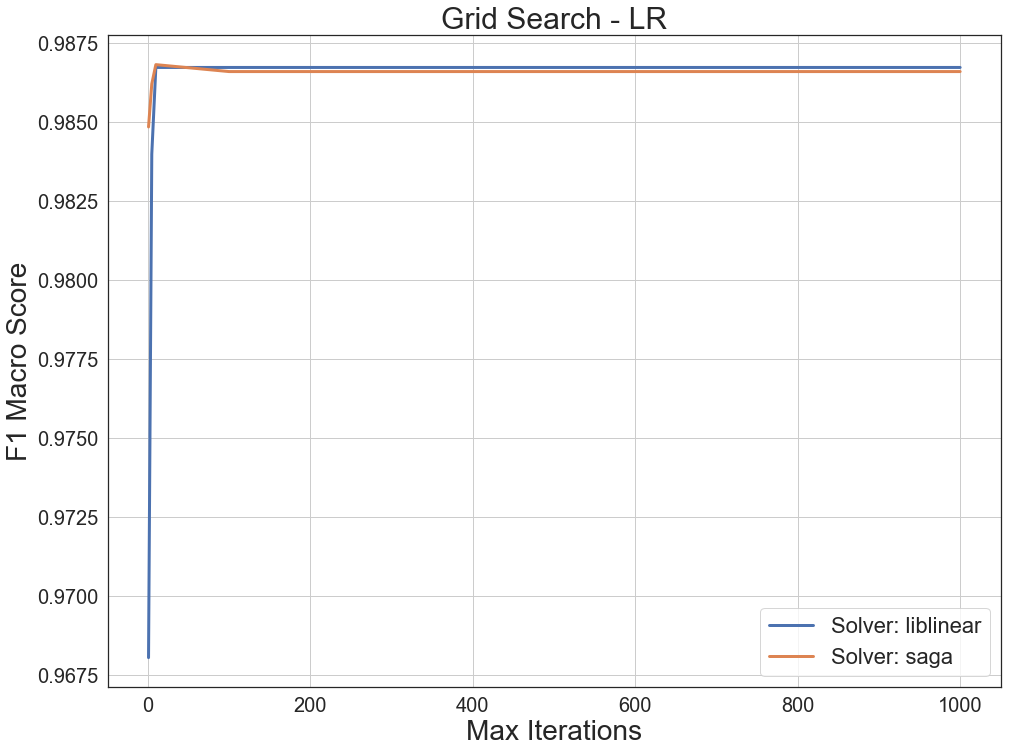

In [169]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'Grid Search - LR', 'logreg_default')

## Default RF

In [218]:
params = {'n_estimators': [20,50,100,200,250], 'max_features': ['sqrt', 'log2']}

In [219]:
n_estimators = [20,50,100,200,250]
max_features = ['sqrt', 'log2']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


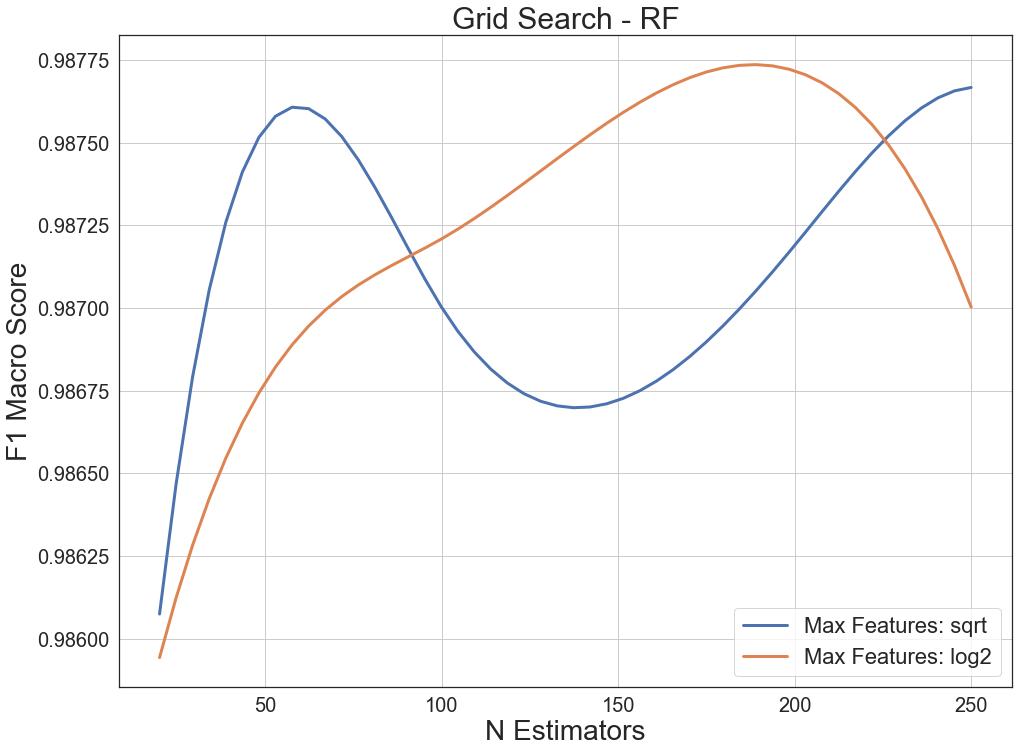

In [223]:
plot_grid_search(results.sort_values(by=['param_max_features','param_n_estimators']), n_estimators, max_features, 'N Estimators', 'Max Features', 'Grid Search - RF', 'random_forest_default')

## L2 - Lambda

In [225]:
params = {'penalty':['l2'], 'C': [0.01, 0.1, 1, 10],'class_weight': ['balanced'], 'max_iter': [10,50,75,150,300], 'multi_class': ['auto'], 'solver': ['sag']}

In [226]:
max_iter = [10,50,75,150,300]
C = [0.01, 0.1, 1, 10]

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


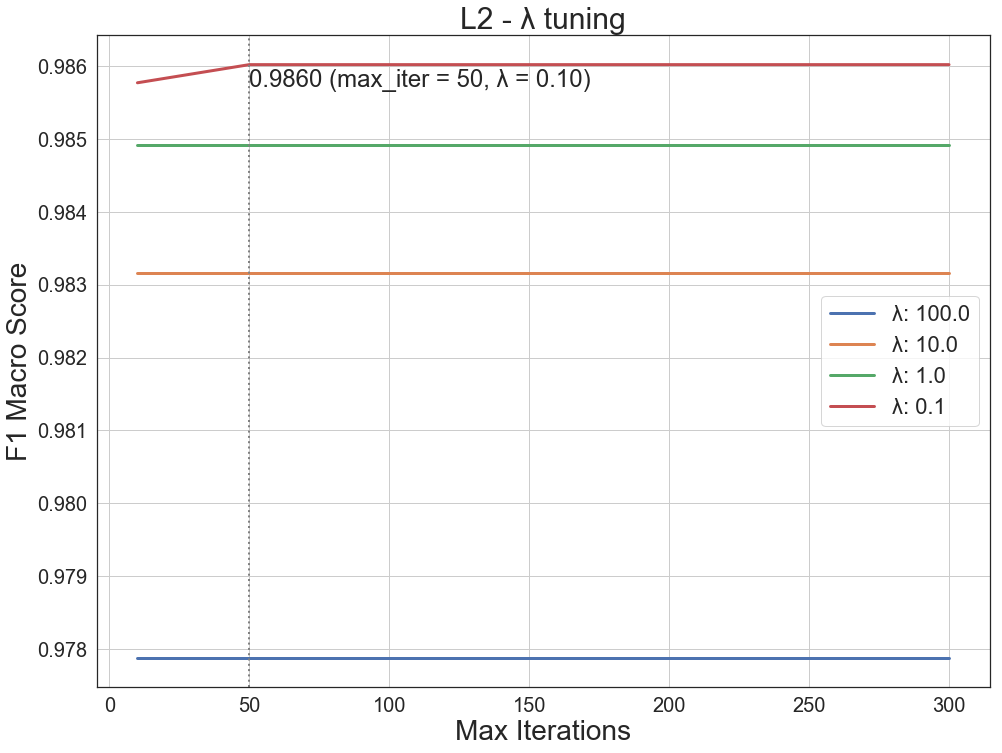

In [241]:
plot_grid_search(results.sort_values(by=['param_C', 'param_max_iter']), max_iter, C, 'Max Iterations', 'λ', 'L2 - λ tuning','logreg_l2_lambda')

## L1 - Lambda

In [242]:
params = {'penalty':['l1'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [10,50,75,150,300], 'multi_class': ['auto'], 'solver': ['liblinear']}

In [243]:
max_iter = [10,50,75,150,300]
C = [0.01, 0.1, 1, 10]

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


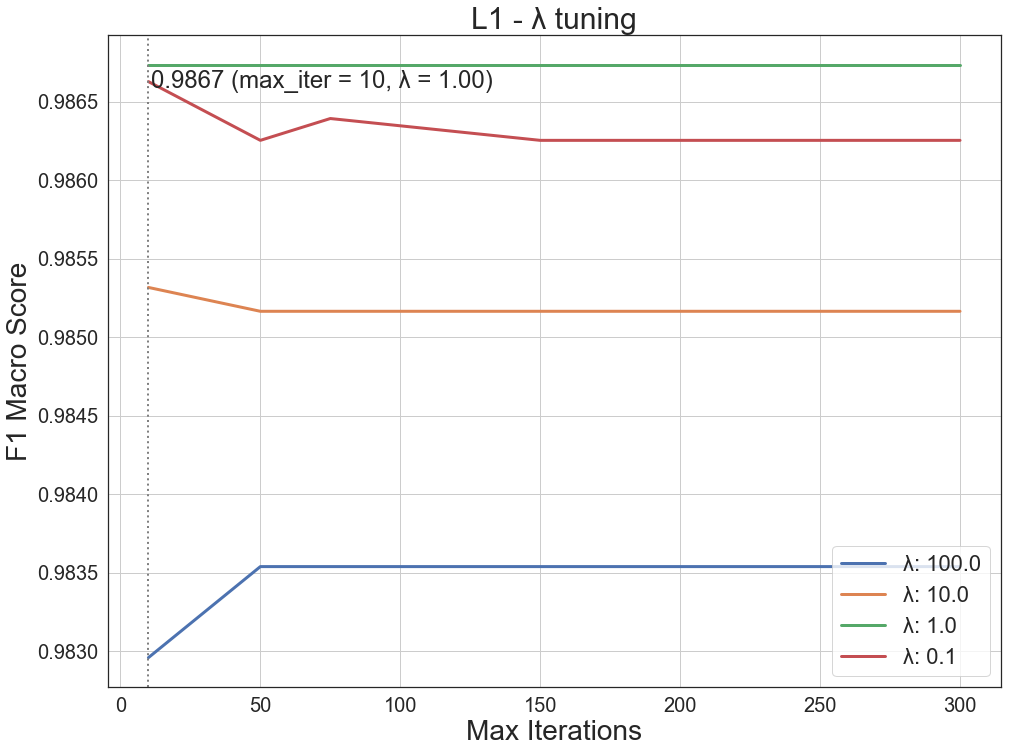

In [249]:
plot_grid_search(results.sort_values(by=['param_C', 'param_max_iter']), max_iter, C, 'Max Iterations', 'λ', 'L1 - λ tuning','logreg_l1_lambda')

## L2 - Close

In [251]:
params = {'class_weight': ['balanced'], 'max_iter': [3,5,10,20,30,50,75], 'multi_class': ['auto'], 'solver': ['newton-cg', 'lbfgs', 'sag']}

In [252]:
max_iter = [3,5,10,20,30,50,75]
solver = ['newton-cg', 'lbfgs', 'sag']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


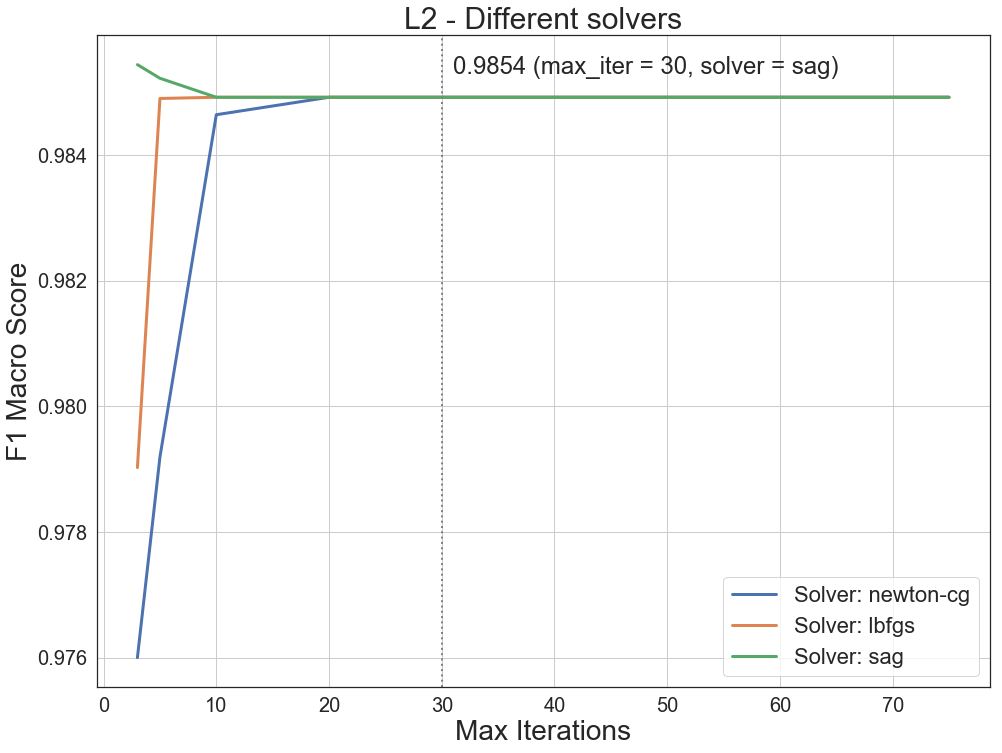

In [256]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'L2 - Different solvers','logreg_l2_close')

In [286]:
params = {'class_weight': ['balanced'], 'max_iter': [100,500,2000,5000], 'multi_class': ['auto'], 'solver': ['newton-cg', 'lbfgs', 'sag']}

In [287]:
max_iter = [100,500,2000,5000]
solver = ['newton-cg', 'lbfgs', 'sag']

In [288]:
results = grid_eval(LogisticRegression(), X, y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


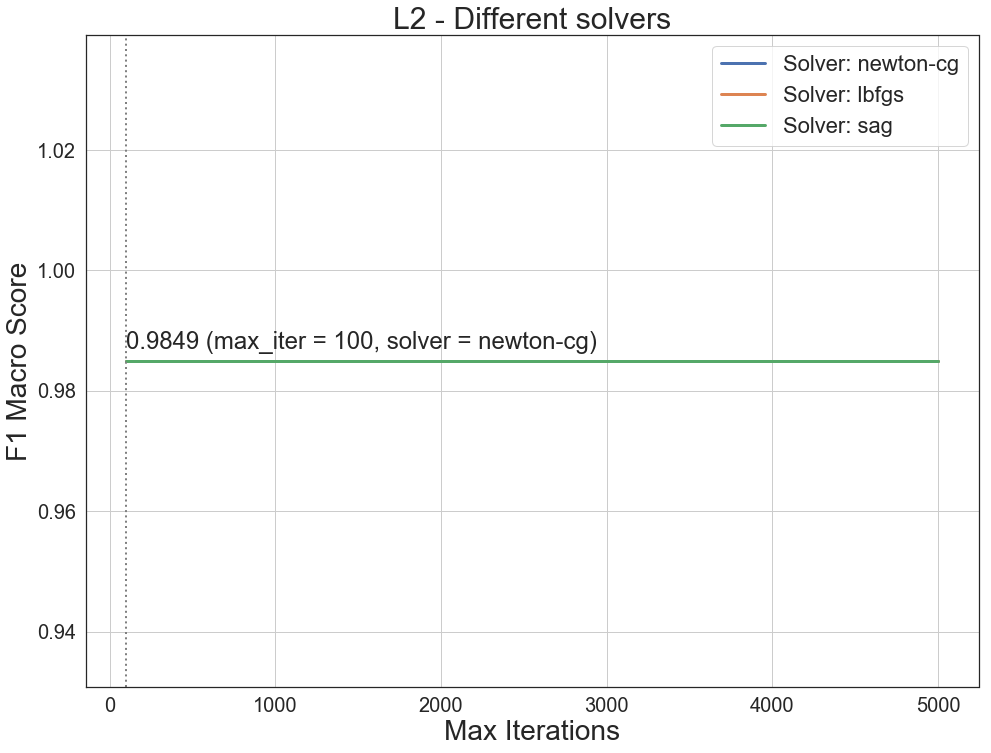

In [292]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'L2 - Different solvers','logreg_l2_far')

## L1 - Close

In [300]:
params = {'penalty': ['l1'], 'max_iter': [3,5,10,20,30,50,75,150], 'multi_class': ['auto'], 'solver': ['liblinear', 'saga']}

In [301]:
max_iter = [3,5,10,20,30,50,75,150]
solver = ['liblinear','saga']

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


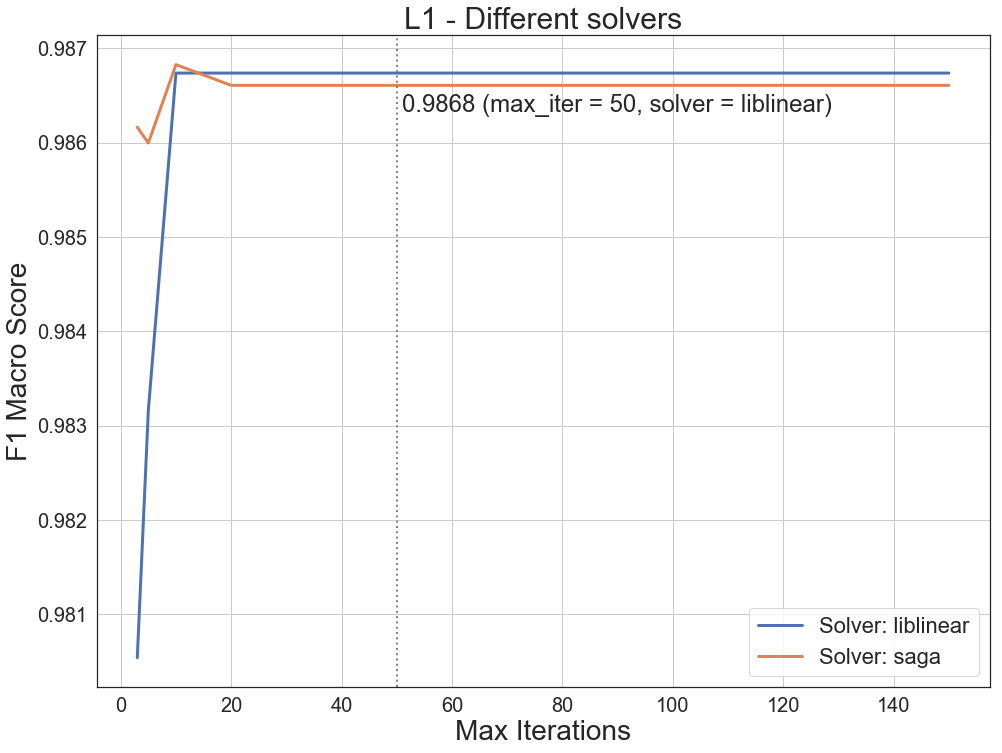

In [306]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'L1 - Different solvers','logreg_l1_close')

## L1 - Far

In [335]:
params = {'penalty':['l1'], 'max_iter': [100,500,2000,5000], 'multi_class': ['auto'], 'solver': ['liblinear','saga']}

In [336]:
max_iter = [100,500,2000,5000]
solver = ['liblinear','saga']

In [337]:
results = grid_eval(LogisticRegression(), X, y, params)

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/Lorenzo/anaconda/lib/

/Users/Lorenzo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/Lorenzo/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


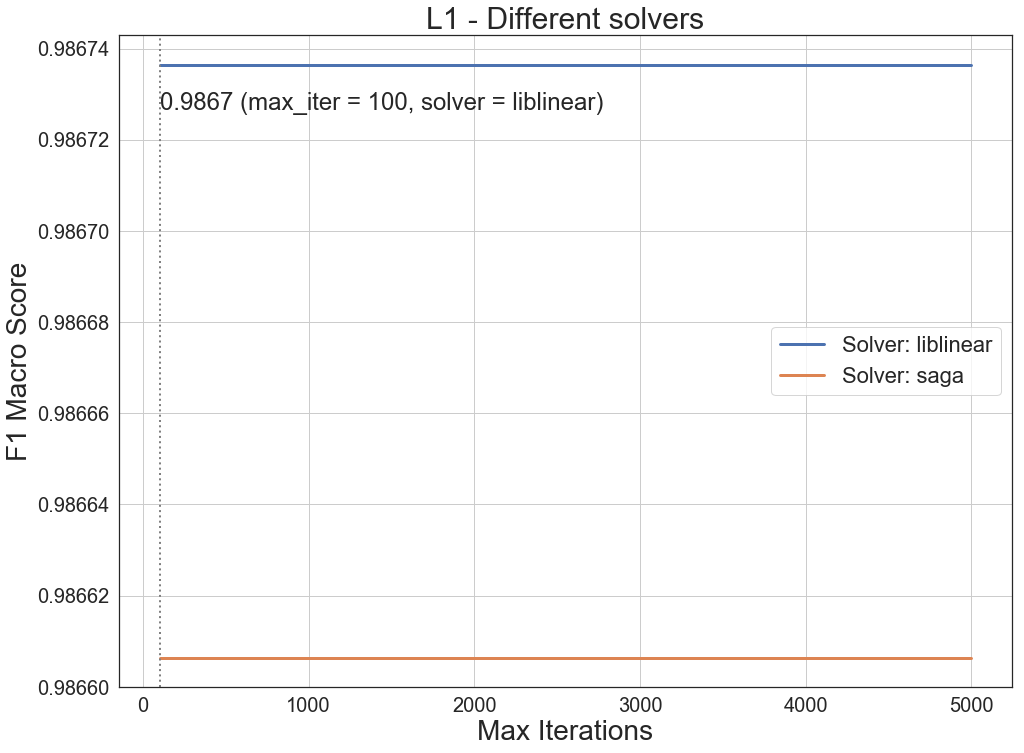

In [340]:
plot_grid_search(results.sort_values(by=['param_solver', 'param_max_iter']), max_iter, solver, 'Max Iterations', 'Solver', 'L1 - Different solvers','logreg_l1_far')

In [329]:
lr = LogisticRegression(max_iter=80, multi_class='auto', solver = 'liblinear', penalty='l1')

In [209]:
cv = cross_validate(lr, X, y, cv=10, scoring=["f1_macro", "precision_macro", 'recall_macro'])

In [210]:
cv['test_precision_macro'].mean()

0.9871308428554088

In [212]:
cv['test_recall_macro'].mean()

0.9864511471034871

In [211]:
cv['test_f1_macro'].mean()

0.986733950290731

In [330]:
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=80, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [214]:
pickle.dump(lr, open("../scripts/lr.model", "wb"))

In [331]:
coeff = []
for j in range (0,12):
    val = 0
    for i in range (0,4):
        val += lr.coef_[i][j]
    coeff.append(val/4)

In [332]:
coeff[:4]

[-0.66054913071925,
 -0.1858216352810207,
 -0.4650928433070859,
 -0.8308468117763605]

In [333]:
coeff[4:8]

[0.5785666109049167, -0.054432407812225775, 0.0723959840891534, 0.0]

In [334]:
coeff[8:12]

[1.993016220647479, 2.1474220565412576, 2.0497725546036993, 2.5711851399869863]

In [323]:
lr = LogisticRegression(max_iter=80, multi_class='auto', solver = 'saga', penalty='l2')

In [324]:
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=80, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [325]:
coeff = []
for j in range (0,12):
    val = 0
    for i in range (0,4):
        val += lr.coef_[i][j]
    coeff.append(val/4)

In [326]:
coeff[:4]

[3.469446951953614e-16,
 1.7763568394002505e-15,
 3.247402347028583e-15,
 -1.1157741397482823e-14]

In [327]:
coeff[4:8]

[2.8033131371785203e-15,
 -1.1823875212257917e-14,
 9.797718192317006e-15,
 4.801714581503802e-15]

In [328]:
coeff[8:12]

[8.715250743307479e-15,
 -8.382183835919932e-15,
 1.0547118733938987e-14,
 -1.7319479184152442e-14]